In [1]:
import numpy as np
import matplotlib as m
import matplotlib.pyplot as plt
import copy as c
import scipy.stats as sct
import scipy.optimize as sco
import scipy.spatial as scp
import pyemma
import pyemma.plots as mplt
import pyemma.coordinates as coor
import gromacs as gmx

/home/jayakrishnak/softwares/anaconda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


NOTE: Some configuration directories are not set up yet: 
	/home/jayakrishnak/.gromacswrapper
	/home/jayakrishnak/.gromacswrapper/qscripts
	/home/jayakrishnak/.gromacswrapper/templates
NOTE: You can create the configuration file and directories with:
	>>> import gromacs
	>>> gromacs.config.setup()


## bound state

In [2]:
traj_list = ['../../1_pbc_trajs/bound_.xtc']

In [3]:
top = coor.featurizer('../../0_references/bound_open.pdb')

<font size=4>
    protein - resid 9 to 236 <br><br>
    gdm     - resid 237  <br><br>
</font>

In [5]:
pair_list = np.array([[i,237] for i in range(9,236+1)])

In [5]:
top.add_residue_mindist(residue_pairs=pair_list-9, scheme='closest-heavy', periodic=False)

In [6]:
mindist_bound = coor.source(traj_list, features=top).get_output()[0]

getting output of FeatureReader:   0%|                                                                        …

In [20]:
np.save('mindist_bound.npy', mindist_bound)

## intermediate state

In [35]:
traj_list = ['../../1_pbc_trajs/binding_bound_parts/binding_13.xtc', 
             '../../1_pbc_trajs/binding_bound_parts/binding_21.xtc']

In [36]:
topi = coor.featurizer('../../0_references/bound_open.pdb')
topi.add_residue_mindist(residue_pairs=pair_list-9, scheme='closest-heavy', periodic=False)

In [54]:
mindist_intermediate = coor.source(traj_list, features=topi).get_output()

In [59]:
mindist_intermediate = np.concatenate((mindist_intermediate))

In [60]:
np.save('mindist_intermediate.npy', mindist_intermediate)

## Analysis

In [23]:
mindist_bound = np.load('mindist_bound.npy')
mindist_intermediate = np.load('mindist_intermediate.npy')[-200001:]

In [24]:
mean_bound = np.mean(mindist_bound, axis=0)

<BarContainer object of 228 artists>

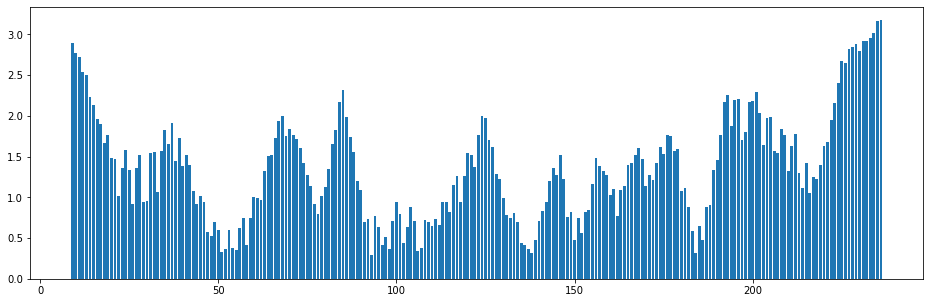

In [25]:
fig,ax = plt.subplots(1,figsize=(16,5))
ax.bar(pair_list[:,0], mean_bound)

In [26]:
np.where(mean_bound <= 0.51)[0].shape

(19,)

In [27]:
cutt = 0.51
prob_bound = np.zeros((len(pair_list)))
total=mindist_bound.shape[0]
for i in range(mindist_bound.shape[1]):
    prob_bound[i] = np.where(mindist_bound[:,i] <= cutt)[0].shape[0] / total

<BarContainer object of 228 artists>

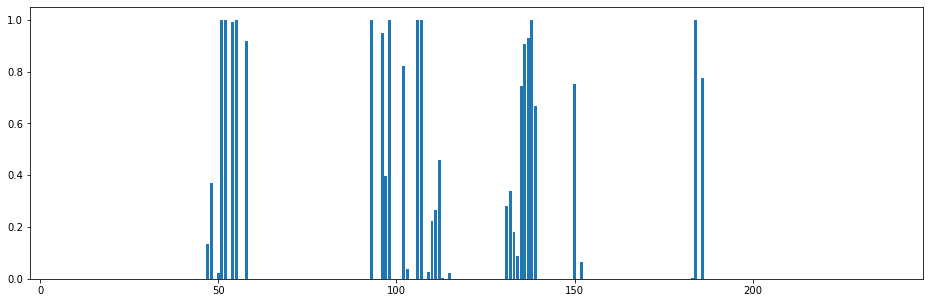

In [28]:
fig,ax = plt.subplots(1,figsize=(16,5))
ax.bar(pair_list[:,0], prob_bound)

In [29]:
np.where(prob_bound >= 0.5)[0].shape

(19,)

In [32]:
mean_intermediate = np.mean(mindist_intermediate, axis=0)

<BarContainer object of 228 artists>

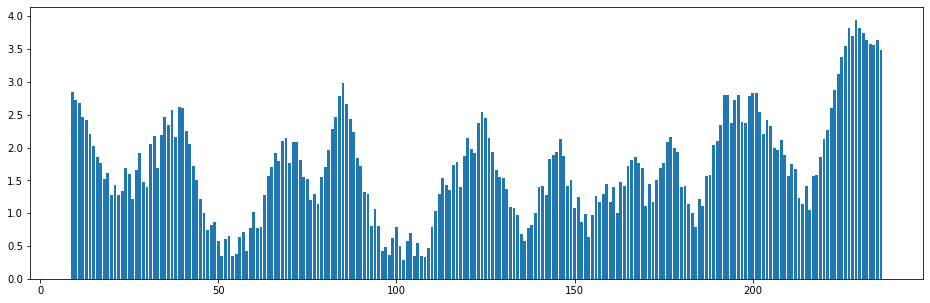

In [33]:
fig,ax = plt.subplots(1,figsize=(16,5))
ax.bar(pair_list[:,0], mean_intermediate)

In [34]:
np.where(mean_intermediate <= 0.51)[0].shape

(13,)

In [35]:
cutt = 0.51
prob_intermediate = np.zeros((len(pair_list)))
total=mindist_intermediate.shape[0]
for i in range(mindist_intermediate.shape[1]):
    prob_intermediate[i] = np.where(mindist_intermediate[:,i] <= cutt)[0].shape[0] / total

<BarContainer object of 228 artists>

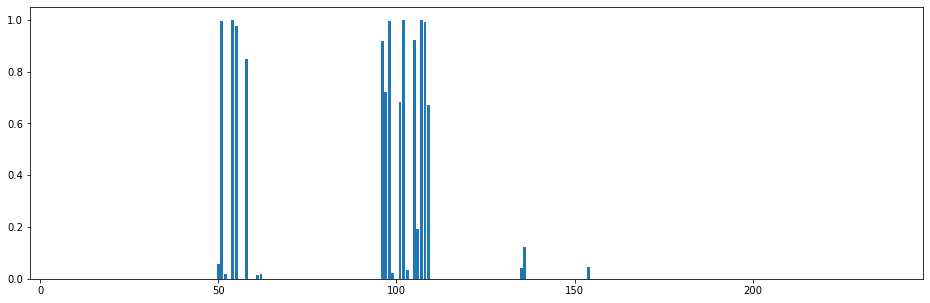

In [36]:
fig,ax=plt.subplots(1,figsize=(16,5))
ax.bar(pair_list[:,0], prob_intermediate)

In [37]:
np.where(prob_intermediate >= 0.5)[0].shape

(13,)

## important residues

In [38]:
seq = []
res=None
for i in open('../../0_references/bound_open.pdb','r'):
    i = i.strip().split()
    if i[0] == 'ATOM':
        if i[4] != res:
            res = i[4]
            if i[3] != 'GDM':
                seq.append(i[3])
seq = np.array(seq)

In [39]:
seq.shape

(228,)

In [43]:
cutt = 0.5
imp_res_bound = []
imp_res_intermediate = []

for i in range(len(pair_list)):
    if prob_bound[i] >= cutt:
        imp_res_bound.append([seq[i]+str(pair_list[i][0]), prob_bound[i]])

    if prob_intermediate[i] >= cutt:
        imp_res_intermediate.append([seq[i]+str(pair_list[i][0]), prob_intermediate[i]])
        
imp_res_bound = np.array(imp_res_bound)
imp_res_intermediate = np.array(imp_res_intermediate)

all_pairs = np.unique( np.concatenate((imp_res_bound[:,0], imp_res_intermediate[:,0])) )
# pp = np.concatenate((imp_res_bound[:,0], imp_res_intermediate[:,0]))
# all_pairs = []
# for i in pp:
#     if i not in all_pairs:
#         all_pairs.append(i)

imp_res_all = []
for i in all_pairs:
    bb = imp_res_bound[imp_res_bound[:,0] == i]
    if bb.shape[0] == 1:
        bb = bb[0][1]
    else:
        bb = 0
        
    ii = imp_res_intermediate[imp_res_intermediate[:,0] == i]
    if ii.shape[0] == 1:
        ii = ii[0][1]
    else:
        ii = 0
        
    imp_res_all.append([i, bb, ii])
imp_res_all = np.array(imp_res_all)

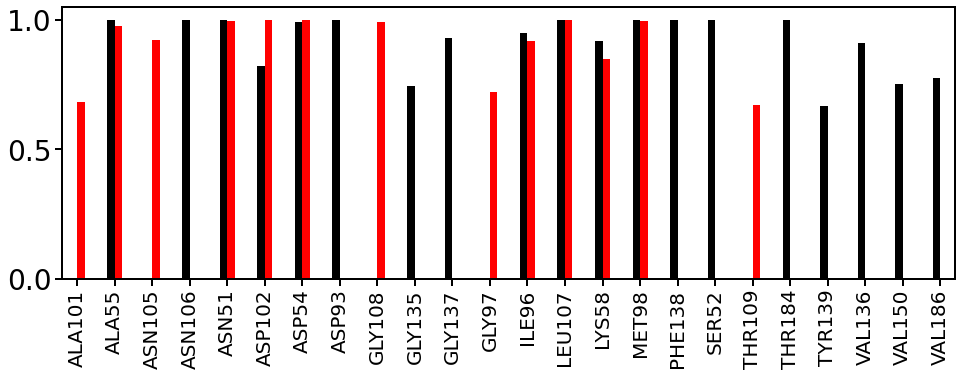

In [44]:
width=0.2
xrange = np.arange(len(imp_res_all))
fig,ax=plt.subplots(1,figsize=(16,5))
ax.bar(xrange-width/2, imp_res_all[:,1].astype(float), width=width, color='black')
ax.bar(xrange+width/2, imp_res_all[:,2].astype(float), width=width, color='red')
ax.set_xlim(-width*2,len(imp_res_all)+width*2-1)
ax.set_xticks(xrange, imp_res_all[:,0], rotation=90)
ax.spines[:].set_linewidth(2)
ax.tick_params('x',length=7, width=2, labelsize=20)
ax.tick_params('y',length=7, width=2, labelsize=28)
plt.show()

## making beta factor files

In [42]:
fbound = open('apo_bound.pdb','w')
fintermediate = open('apo_intermediate.pdb','w')
fdiff = open('apo_difference.pdb','w')

for l in open('apo_open.pdb','r'):
    i = l.strip().split()
    
    if i[0] == 'ATOM':
        ind = int(i[4]) - 9
        fbound.write( l[:62] + "{:.2f}   \n".format(prob_bound[ind]) )
        fintermediate.write( l[:62] + "{:.2f}   \n".format(prob_intermediate[ind]) )
        fdiff.write( l[:62] + "{:.2f}   \n".format(prob_bound[ind]-prob_intermediate[ind]) )
        
    else:
        fbound.write(l)
        fintermediate.write(l)
        fdiff.write(l)
    
fbound.close()
fintermediate.close()
fdiff.close()

## colorbar for lcontacts

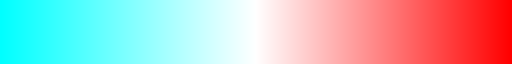

In [11]:
cb1 = m.cm.colors.LinearSegmentedColormap.from_list('cb1', ['cyan','white','red'], N=1024)
cb1

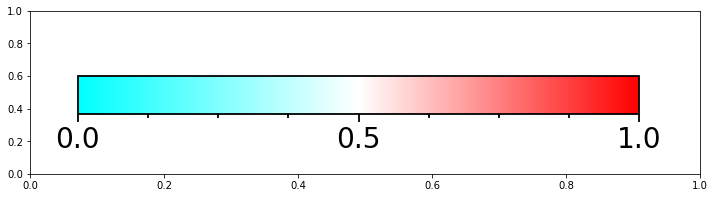

In [45]:
fig,ax = plt.subplots(1,figsize=(12,3))
cax = fig.add_axes([0.18,0.4,0.65,0.18])
cb = plt.colorbar(mappable=m.cm.ScalarMappable(cmap=cb1), cax=cax, orientation='horizontal')
cb.ax.set_xticks([0,0.5,1])
cb.ax.tick_params(labelsize=28, length=8, width=1.8)
cb.ax.spines[:].set_linewidth(1.8)
cb.ax.xaxis.set_minor_locator(m.ticker.AutoMinorLocator(4))
cb.ax.tick_params(which='minor', length=4, width=1.8)
plt.savefig('cb1.pdf')